<a href="https://colab.research.google.com/github/AbhilashDatta/Tumor-Segmentation-and-Generation/blob/main/BraTS_Segmentation_UNET3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports....

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from glob import glob
import nibabel as nib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from tqdm import tqdm
import enum
from skimage.transform import resize
import time
from scipy import stats
import random
from IPython import display
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [ ]:
scaler = MinMaxScaler()

In [ ]:
!pip install torchio
import torchvision
import torchio as tio

     |████████████████████████████████| 156 kB 2.8 MB/s 
     |████████████████████████████████| 48.4 MB 5.2 kB/s 


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Pre-processing...

In [ ]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTr" 
TRAIN_MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsTr"
VAL_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesVal"
VAL_MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsVal" 
TEST_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTs" 

In [ ]:
MODEL_CHECKPOINT_DIR = "/content/drive/MyDrive/cp/checkpoints"
BEST_ONE_DIR = "/content/drive/MyDrive/cp/bestone"

In [ ]:
def make_list(s):
  l = sorted(os.listdir(s))
  return l

In [ ]:
images_train = make_list(TRAIN_IMG_DIR)
masks_train = make_list(TRAIN_MASK_DIR)
images_val = make_list(VAL_IMG_DIR)
masks_val = make_list(VAL_MASK_DIR)
images_test = make_list(TEST_IMG_DIR)
len(images_train), len(masks_train), len(images_val), len(masks_val), len(images_test)

(434, 434, 50, 50, 265)

In [ ]:
#list of img and mask path......TRAIN
img_train_paths = []
mask_train_paths = []
#list of img and mask path......VAL
img_val_paths = []
mask_val_paths = []
#list of img path.......TEST
img_test_paths = []

for idx in range(len(images_train)):
  img_train_paths.append(os.path.join(TRAIN_IMG_DIR, images_train[idx]))
  mask_train_paths.append(os.path.join(TRAIN_MASK_DIR, masks_train[idx]))

for idx in range(len(images_val)):
  img_val_paths.append(os.path.join(VAL_IMG_DIR, images_val[idx]))
  mask_val_paths.append(os.path.join(VAL_MASK_DIR, masks_val[idx]))

for idx in range(len(images_test)):
  img_test_paths.append(os.path.join(TEST_IMG_DIR, images_test[idx]))

len(img_train_paths), len(mask_train_paths), len(img_val_paths), len(mask_val_paths), len(img_test_paths)

(434, 434, 50, 50, 265)

In [ ]:
imagesTr_nparray  = '/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTr_nparray'
imagesTs_nparray  = '/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTs_nparray'
imagesVal_nparray = '/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesVal_nparray'
labelsTr_nparray  = '/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsTr_nparray'
labelsVal_nparray = '/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsVal_nparray'

In [ ]:
# def preprocess(img_paths=None, mask_paths=None, img_names=None, mask_name=None, imarray_path=None, marray_path=None):
#   if img_paths: 
#     for i in range(1,len(img_paths)):
#       image = nib.load(img_paths[i]).get_fdata(dtype=np.float32)
#       image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
#       image = image[56:184, 56:184, 73:121]
#       image0 = image[:,:,:,0]
#       image2 = image[:,:,:,2]
#       image3 = image[:,:,:,3]
#       image = np.stack((image0,image2,image3),axis=3)

#       if mask_paths:
#         mask = nib.load(mask_paths[i]).get_fdata(dtype=np.float32)
#         mask = mask.astype(np.uint8)
#         mask = mask[56:184, 56:184, 73:121]
#         # mask = to_categorical(mask, num_classes=4)

#         # print(img_names[i])

#         val, counts = np.unique(mask, return_counts=True)
#         if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0.............
#             mask = to_categorical(mask, num_classes=4)
#             np.save(imarray_path + '/' + img_names[i][:9] + '.npy', image)
#             np.save(marray_path + '/' + mask_name[i][:9] + '.npy', mask)            
      
#       if mask_paths is None:
#         np.save(imarray_path + '/' + img_names[i][:9] + '.npy', image)

In [ ]:
# preprocess(img_paths=img_test_paths, img_names=images_test, imarray_path=imagesTs_nparray)

In [ ]:
# preprocess(img_train_paths, mask_train_paths, images_train, masks_train, imagesTr_nparray, labelsTr_nparray)

In [ ]:
# preprocess(img_val_paths, mask_val_paths, images_val, masks_val, imagesVal_nparray, labelsVal_nparray)

In [ ]:
np_images_train = make_list(imagesTr_nparray)
np_masks_train = make_list(labelsTr_nparray)
np_images_val = make_list(imagesVal_nparray)
np_masks_val = make_list(labelsVal_nparray)
np_images_test = make_list(imagesTs_nparray)
len(np_images_train), len(np_masks_train), len(np_images_val), len(np_masks_val), len(np_images_test)

(370, 370, 47, 47, 264)

In [ ]:
#list of img and mask path......TRAIN
np_img_train_paths = []
np_mask_train_paths = []
#list of img and mask path......VAL
np_img_val_paths = []
np_mask_val_paths = []
#list of img path.......TEST
np_img_test_paths = []

for idx in range(len(np_images_train)):
  np_img_train_paths.append(os.path.join(imagesTr_nparray, np_images_train[idx]))
  np_mask_train_paths.append(os.path.join(labelsTr_nparray, np_masks_train[idx]))

for idx in range(len(np_images_val)):
  np_img_val_paths.append(os.path.join(imagesVal_nparray, np_images_val[idx]))
  np_mask_val_paths.append(os.path.join(labelsVal_nparray, np_masks_val[idx]))

for idx in range(len(np_images_test)):
  np_img_test_paths.append(os.path.join(imagesTs_nparray, np_images_test[idx]))

len(np_img_train_paths), len(np_mask_train_paths), len(np_img_val_paths), len(np_mask_val_paths), len(np_img_test_paths)

(370, 370, 47, 47, 264)

# Dataset....

In [ ]:
class BRaTSDataset(Dataset):
  def __init__(self, img_paths=None, mask_paths=None, transform_imgs=None, transform_mask=None):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transform_imgs = transform_imgs
    self.transform_mask = transform_mask
    if self.mask_paths is not None:
      assert len(self.img_paths) == len(self.mask_paths)
    self.images = len(self.img_paths) #list all the files present in that folder...
  
  def __len__(self):
    return len(self.img_paths) #length of dataset
  
  def __getitem__(self, index):
    img_path = self.img_paths[index]
    if self.mask_paths is not None:
      mask_path = self.mask_paths[index]

    image = np.load(img_path)
    image = torch.from_numpy(image)
    image = image.permute(3,0,1,2)

    if self.mask_paths is not None:
      mask = np.load(mask_path)
      mask = torch.from_numpy(mask)
      mask = mask.permute(3,0,1,2)
 
    if self.transform_imgs is not None:
      image = training_transforms(image)
    if self.transform_mask is not None:
      mask = training_transforms(mask)
    
    if self.mask_paths is not None:
      return image, mask
    if self.mask_paths is None:
      return image

In [ ]:
training_transforms = tio.Compose(
    [
    #  tio.RandomFlip(),
    #  tio.RandomAffine(degrees= 25),
    #  tio.RandomBlur(), 
    #  tio.RandomNoise(mean=0.6),
    #  tio.RandomGamma(),
    #  tio.RandomBiasField(p=0.3),
    #  tio.RandomElasticDeformation()
 ]
)

train_ds = BRaTSDataset(
        img_paths=np_img_train_paths,
        mask_paths=np_mask_train_paths,
        transform_imgs=training_transforms,
        transform_mask=training_transforms
    )

train_loader = DataLoader(
        train_ds,
        batch_size=4,
        num_workers=0,
        shuffle=True,
    )

In [ ]:
I,M = next(iter(train_loader))
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 4, 128, 128, 48])


In [ ]:
M=np.argmax(M, axis=1)
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 128, 128, 48])


1 1


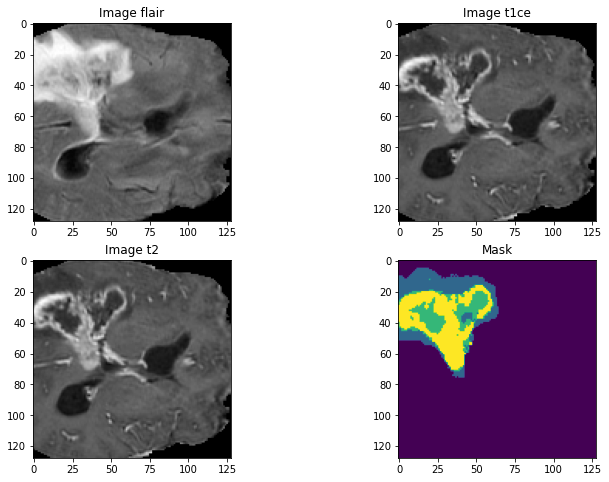

In [ ]:
n_slice=random.randint(0, M.shape[3])
plt.figure(figsize=(12, 8))
no=1
print(n_slice,no)

plt.subplot(221)
plt.imshow(I[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(M[no,:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
val_ds = BRaTSDataset(
        img_paths=np_img_val_paths,
        mask_paths=np_mask_val_paths
    )

val_loader = DataLoader(
        val_ds,
        batch_size=4,
        num_workers=0,
        shuffle=False,
    )

I,M = next(iter(val_loader))
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 4, 128, 128, 48])


In [ ]:
M=np.argmax(M, axis=1)
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 128, 128, 48])


8 2


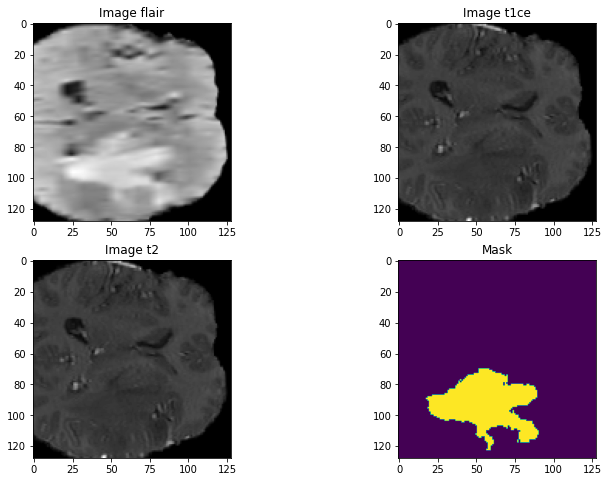

In [ ]:
n_slice=random.randint(0, M.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(I[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(M[no,:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
test_ds = BRaTSDataset(
        img_paths=np_img_test_paths
    )

test_loader = DataLoader(
        test_ds,
        batch_size=4,
        num_workers=0,
        shuffle=False,
    )

I = next(iter(test_loader))
print("image...",I.shape)

image... torch.Size([4, 3, 128, 128, 48])


11 2


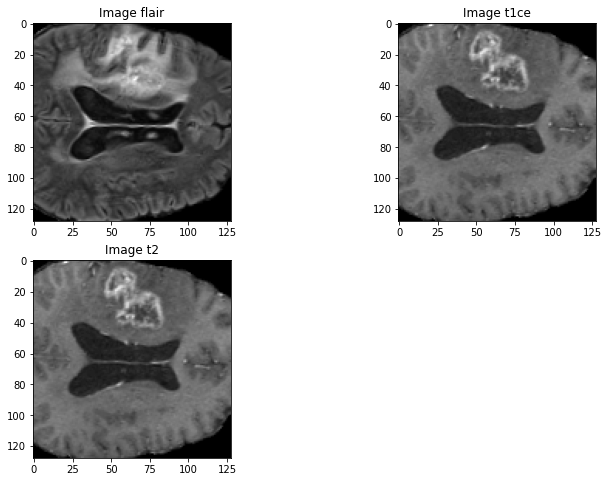

In [ ]:
n_slice=random.randint(0, M.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(I[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(M[no,:,:,n_slice])
# plt.title('Mask')
plt.show()

# Model...

In [ ]:
class ProjectExciteLayer(nn.Module):

    def __init__(self, num_channels, reduction_ratio=8):

        super(ProjectExciteLayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.relu = nn.ReLU()
        self.conv_c = nn.Conv3d(in_channels=num_channels, out_channels=num_channels_reduced, kernel_size=1, stride=1)
        self.conv_cT = nn.Conv3d(in_channels=num_channels_reduced, out_channels=num_channels, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):

        batch_size, num_channels, D, H, W = input_tensor.size()

        # Project:
        # Average along channels and different axes
        squeeze_tensor_w = F.adaptive_avg_pool3d(input_tensor, (1, 1, W))

        squeeze_tensor_h = F.adaptive_avg_pool3d(input_tensor, (1, H, 1))

        squeeze_tensor_d = F.adaptive_avg_pool3d(input_tensor, (D, 1, 1))

        # tile tensors to original size and add:
        final_squeeze_tensor = sum([squeeze_tensor_w.view(batch_size, num_channels, 1, 1, W),
                                    squeeze_tensor_h.view(batch_size, num_channels, 1, H, 1),
                                    squeeze_tensor_d.view(batch_size, num_channels, D, 1, 1)])

        # Excitation:
        final_squeeze_tensor = self.sigmoid(self.conv_cT(self.relu(self.conv_c(final_squeeze_tensor))))
        output_tensor = torch.mul(input_tensor, final_squeeze_tensor)

        return output_tensor

In [ ]:
# ProjectExciteLayer = ProjectExciteLayer(32)
# ProjectExciteLayer(torch.randn((1,32,128, 128, 48))).shape

torch.Size([1, 32, 128, 128, 48])

In [ ]:
class Attention(nn.Module):   #it gives channel attention
    def __init__(self, in_channels, reduced_dim):  #input_shape ---> output_shape
        super(Attention, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), # C x H x W -> C x 1 x 1
            nn.Conv3d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv3d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer

def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d

def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)

def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d

def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)

def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d

def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)

def get_activation(activation: str):
    if activation == 'ReLU':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()
    elif activation == 'PReLU':
        return nn.PReLU()

def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)

class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x

class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
        
        self.Attention = Attention(self.out_channels,16)
        # self.ProjectExciteLayer = ProjectExciteLayer(self.out_channels)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        
        y = self.Attention(y)
        # y = self.ProjectExciteLayer(y)

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling

class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


In [ ]:
class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.kaiming_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

In [ ]:
# model = UNet(in_channels=3,
#              out_channels=4,
#              n_blocks=4,
#              start_filters=32,
#              activation='ReLU',
#              normalization='batch',
#              conv_mode='same',
#              dim=3).to(device)

# x = torch.randn(size=(6, 3, 128, 128, 48), dtype=torch.float32)
# with torch.no_grad():
#     out = model(x)

# print(f'Out: {out.shape}')

# Loss...

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):        
        
        # inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice, dice

DiceLoss = DiceLoss()

In [ ]:
ALPHA = 0.8
BETA = 0.2
GAMMA = 0.75

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        c,d = DiceLoss(inputs, targets)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky, d

FocalTverskyLoss = FocalTverskyLoss()

# Training pipeline....

In [ ]:
MODEL_CHECKPOINT_DIR = "/content/Untitled Folder"
BEST_ONE_DIR = "/content/Untitled Folder"

In [ ]:
num_epochs = 100
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
trains = True
current_loss = 200

In [ ]:
def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

In [ ]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

In [ ]:
def save_checkpoint(checkpoint, PATH):
    torch.save(checkpoint, PATH)

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    #model.load_state_dict(checkpoint)
    model.load_state_dict(checkpoint['weights'])
    optimizer.load_state_dict(checkpoint['optimizers'])
    return model, optimizer

In [ ]:
def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler):
    is_training = action == Action.TRAIN
    weights_stem = 'weights'
    global current_loss
    epoch_losses = []
    times = []
    dice_coefs = []
    model.train(is_training)
    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            # print("logits", logits)
            # print(logits.shape, targets.shape)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION) 
            # print("prob" , probabilities)
            # print(probabilities.shape)
            batch_losses, dice_coefficients = FocalTverskyLoss(probabilities, targets) #DiceLoss(probabilities, targets) 
            # print("batch_losses",batch_losses)
            batch_loss = batch_losses.mean()
            dice_coef = dice_coefficients.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()               
            times.append(time.time())
            epoch_losses.append(batch_loss.detach().item())
            dice_coefs.append(dice_coef.item())
    epoch_losses = np.array(epoch_losses)
    dice_coefs = np.array(dice_coefs)
    if is_training:
      scheduler.step(batch_loss)
      checkpoint = {
          'weights': model.state_dict(),
      }
      path = os.path.join(BEST_ONE_DIR, f'{weights_stem}_best_one.pth')
      if epoch_idx == 1:
        current_loss = epoch_losses.mean()
        print("saving best one.....ep1")
        save_checkpoint(checkpoint, path)

      if current_loss > epoch_losses.mean():
        print("saving best one.....")
        save_checkpoint(checkpoint, path)
        current_loss = epoch_losses.mean()
    
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f} and {action.value} dice score: {dice_coefs.mean():0.3f}')
    return times, epoch_losses

In [ ]:
# MODEL_CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/brain/model_checkpoints'
# BEST_ONE_DIR = '/content/drive/MyDrive/Colab Notebooks/brain/model_checkpoints/best_one'

In [ ]:
def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, scheduler))
    for epoch_idx in range(1, num_epochs+1):        
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, scheduler))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer, scheduler))
 
        checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
        'optimizers': optimizer.state_dict(),
        'epoch': epoch_idx
        }
        PATH = os.path.join(MODEL_CHECKPOINT_DIR, f'{weights_stem}_epoch_{epoch_idx}.pth')
        save_checkpoint(checkpoint, PATH)
        # torch.save(model.state_dict(), PATH)

    return np.array(train_losses), np.array(val_losses)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/cp/checkpoints/weights_epoch_27.pth'
# checkpoint = torch.load(checkpoint_path)

In [ ]:
"""without se"""

model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)
# model = UNet(in_channels=4, out_channels=3, dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)
# model.load_state_dict(checkpoint['weights'])
weights_path = 'state_dict.pth'
 
if trains:
    weights_stem = 'weights'
    train_losses, val_losses = train(
        num_epochs,
        train_loader,
        val_loader,
        model,
        optimizer,
        scheduler,
        weights_stem,
    )
 
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with volumes')
ax.legend()
fig.autofmt_xdate()

100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Validation mean loss: 0.801 and Validation dice score: 0.256
Starting epoch 1


100%|██████████| 93/93 [12:31<00:00,  8.09s/it]


saving best one.....ep1
Training mean loss: 0.479 and Training dice score: 0.618


100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


Validation mean loss: 0.263 and Validation dice score: 0.831
Starting epoch 2


100%|██████████| 93/93 [05:02<00:00,  3.26s/it]


saving best one.....
Training mean loss: 0.305 and Training dice score: 0.794


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.243 and Validation dice score: 0.848
Starting epoch 3


100%|██████████| 93/93 [04:59<00:00,  3.22s/it]


saving best one.....
Training mean loss: 0.260 and Training dice score: 0.834


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.223 and Validation dice score: 0.864
Starting epoch 4


100%|██████████| 93/93 [04:57<00:00,  3.19s/it]


saving best one.....
Training mean loss: 0.230 and Training dice score: 0.859


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.217 and Validation dice score: 0.869
Starting epoch 5


100%|██████████| 93/93 [04:54<00:00,  3.16s/it]


saving best one.....
Training mean loss: 0.205 and Training dice score: 0.879


100%|██████████| 12/12 [00:19<00:00,  1.58s/it]


Validation mean loss: 0.196 and Validation dice score: 0.885
Starting epoch 6


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.185 and Training dice score: 0.894


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.150 and Validation dice score: 0.920
Starting epoch 7


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


saving best one.....
Training mean loss: 0.169 and Training dice score: 0.906


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.176 and Validation dice score: 0.900
Starting epoch 8


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


saving best one.....
Training mean loss: 0.155 and Training dice score: 0.916


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.132 and Validation dice score: 0.933
Starting epoch 9


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.144 and Training dice score: 0.924


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.130 and Validation dice score: 0.934
Starting epoch 10


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.135 and Training dice score: 0.930


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.110 and Validation dice score: 0.947
Starting epoch 11


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.128 and Training dice score: 0.935


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.107 and Validation dice score: 0.949
Starting epoch 12


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.119 and Training dice score: 0.941


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.103 and Validation dice score: 0.952
Starting epoch 13


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.112 and Training dice score: 0.946


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.113 and Validation dice score: 0.945
Starting epoch 14


100%|██████████| 93/93 [04:54<00:00,  3.16s/it]


saving best one.....
Training mean loss: 0.107 and Training dice score: 0.949


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.095 and Validation dice score: 0.956
Starting epoch 15


100%|██████████| 93/93 [04:53<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.102 and Training dice score: 0.952


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.095 and Validation dice score: 0.957
Starting epoch 16


100%|██████████| 93/93 [04:53<00:00,  3.16s/it]


saving best one.....
Training mean loss: 0.097 and Training dice score: 0.955


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.090 and Validation dice score: 0.959
Starting epoch 17


100%|██████████| 93/93 [04:54<00:00,  3.17s/it]


saving best one.....
Training mean loss: 0.094 and Training dice score: 0.957


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.079 and Validation dice score: 0.966
Starting epoch 18


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.088 and Training dice score: 0.961


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.089 and Validation dice score: 0.960
Starting epoch 19


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.084 and Training dice score: 0.963


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.071 and Validation dice score: 0.970
Starting epoch 20


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.079 and Training dice score: 0.966


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.079 and Validation dice score: 0.966
Starting epoch 21


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.079 and Training dice score: 0.966


100%|██████████| 12/12 [00:19<00:00,  1.58s/it]


Validation mean loss: 0.077 and Validation dice score: 0.967
Starting epoch 22


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.078 and Training dice score: 0.967


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.074 and Validation dice score: 0.969
Starting epoch 23


100%|██████████| 93/93 [04:49<00:00,  3.12s/it]


saving best one.....
Training mean loss: 0.074 and Training dice score: 0.969


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.068 and Validation dice score: 0.972
Starting epoch 24


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.073 and Training dice score: 0.969


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.068 and Validation dice score: 0.972
Starting epoch 25


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.074 and Training dice score: 0.969


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.068 and Validation dice score: 0.972
Starting epoch 26


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
saving best one.....
Training mean loss: 0.069 and Training dice score: 0.971


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.065 and Validation dice score: 0.974
Starting epoch 27


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.065 and Training dice score: 0.974


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 28


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


saving best one.....
Training mean loss: 0.064 and Training dice score: 0.974


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.062 and Validation dice score: 0.975
Starting epoch 29


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.063 and Training dice score: 0.975


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 30


100%|██████████| 93/93 [04:53<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.063 and Training dice score: 0.975


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 31


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.063 and Training dice score: 0.975


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 32


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.062 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 33


100%|██████████| 93/93 [04:53<00:00,  3.15s/it]


saving best one.....
Training mean loss: 0.061 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 34


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.062 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 35


100%|██████████| 93/93 [04:53<00:00,  3.15s/it]


Training mean loss: 0.062 and Training dice score: 0.975


100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 36


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.061 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 37


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 38


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


Training mean loss: 0.061 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 39


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.061 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.061 and Validation dice score: 0.976
Starting epoch 40


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Epoch    40: reducing learning rate of group 0 to 1.0000e-06.
saving best one.....
Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 41


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 42


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.057 and Validation dice score: 0.978
Starting epoch 43


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 44


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 45


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 46


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 47


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Epoch    47: reducing learning rate of group 0 to 1.0000e-07.
saving best one.....
Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 48


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 49


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


saving best one.....
Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 50


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 51


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 52


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 53


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Epoch    53: reducing learning rate of group 0 to 1.0000e-08.
Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 54


100%|██████████| 93/93 [04:49<00:00,  3.11s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 55


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 56


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 57


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 58


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 59


100%|██████████| 93/93 [04:49<00:00,  3.11s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 60


100%|██████████| 93/93 [04:49<00:00,  3.11s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 61


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 62


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 63


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 64


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 65


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 66


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.064 and Validation dice score: 0.974
Starting epoch 67


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.977
Starting epoch 68


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 69


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.057 and Validation dice score: 0.978
Starting epoch 70


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 71


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 72


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 73


100%|██████████| 93/93 [04:53<00:00,  3.16s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.057 and Validation dice score: 0.978
Starting epoch 74


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 75


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 76


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 77


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.061 and Validation dice score: 0.976
Starting epoch 78


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 79


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.060 and Validation dice score: 0.977
Starting epoch 80


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 81


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


saving best one.....
Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 82


100%|██████████| 93/93 [04:50<00:00,  3.12s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 83


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 84


100%|██████████| 93/93 [04:50<00:00,  3.13s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 85


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 86


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 87


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 88


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 89


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 90


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 91


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 92


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 93


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.061 and Validation dice score: 0.976
Starting epoch 94


100%|██████████| 93/93 [04:52<00:00,  3.15s/it]


Training mean loss: 0.060 and Training dice score: 0.976


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 95


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.978
Starting epoch 96


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.058 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 97


100%|██████████| 93/93 [04:51<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.058 and Validation dice score: 0.977
Starting epoch 98


100%|██████████| 93/93 [04:53<00:00,  3.16s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Validation mean loss: 0.060 and Validation dice score: 0.976
Starting epoch 99


100%|██████████| 93/93 [04:51<00:00,  3.13s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.059 and Validation dice score: 0.977
Starting epoch 100


100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Training mean loss: 0.059 and Training dice score: 0.977


100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


Validation mean loss: 0.057 and Validation dice score: 0.978


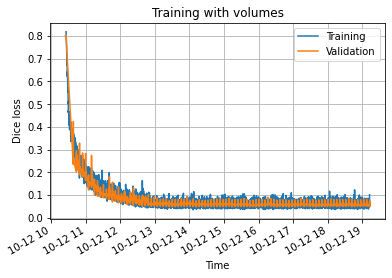

In [ ]:
"""with se"""

model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)
# model = UNet(in_channels=4, out_channels=3, dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
# model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)
# model.load_state_dict(checkpoint['weights'])
weights_path = 'state_dict.pth'
 
if trains:
    weights_stem = 'weights'
    train_losses, val_losses = train(
        num_epochs,
        train_loader,
        val_loader,
        model,
        optimizer,
        scheduler,
        weights_stem,
    )
 
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with volumes')
ax.legend()
fig.autofmt_xdate()

In [ ]:
"""with pe"""

model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)
# model = UNet(in_channels=4, out_channels=3, dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
# model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)
# model.load_state_dict(checkpoint['weights'])
weights_path = 'state_dict.pth'
 
if trains:
    weights_stem = 'weights'
    train_losses, val_losses = train(
        num_epochs,
        train_loader,
        val_loader,
        model,
        optimizer,
        scheduler,
        weights_stem,
    )
 
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with volumes')
ax.legend()
fig.autofmt_xdate()

# Inference....

In [ ]:
model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/cp/checkpoints/weights_epoch_33.pth'
model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)

In [ ]:
model.eval()
with torch.no_grad():
  for batch_idx, (inputs,outputs) in enumerate(tqdm(val_loader)):
    # inputs, targets = prepare_batch(batch, device)
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    logits = model(inputs).softmax(dim=CHANNELS_DIMENSION)

    # l = logits.cpu()
    # l = np.argmax(l, axis=1)
    # i = inputs.cpu()
    # o = outputs.cpu()
    # 0 = np.argmax(o, axis=1)

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


In [ ]:
l = logits.cpu()
l = np.argmax(l, axis=1)
i = inputs.cpu()
o = outputs.cpu()
o = np.argmax(o, axis=1)

1 2


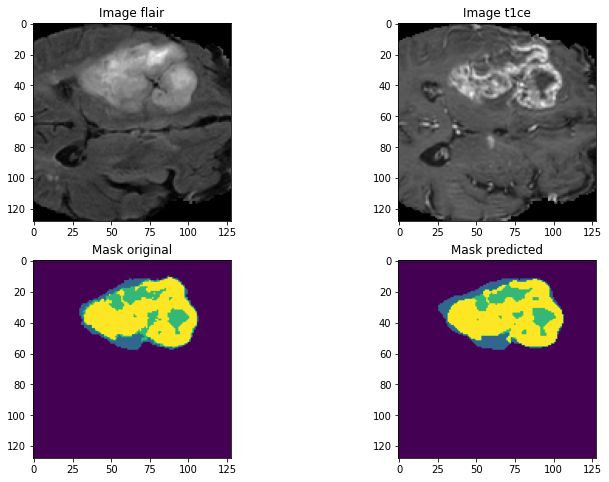

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

34 1


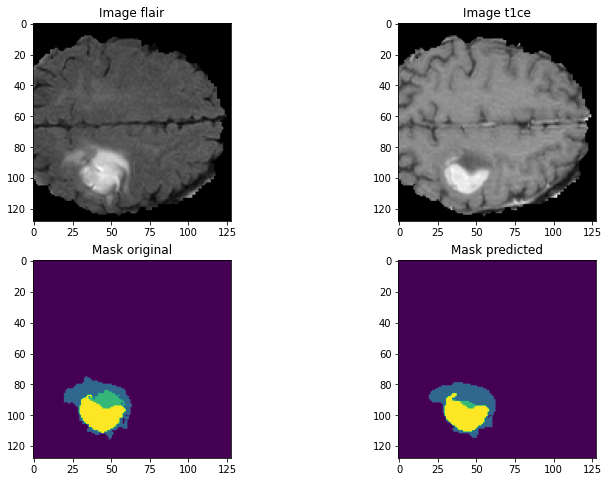

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=1
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

4 3


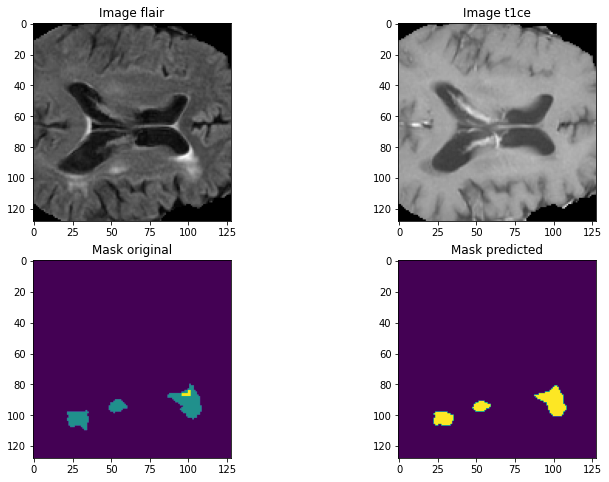

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

26 0


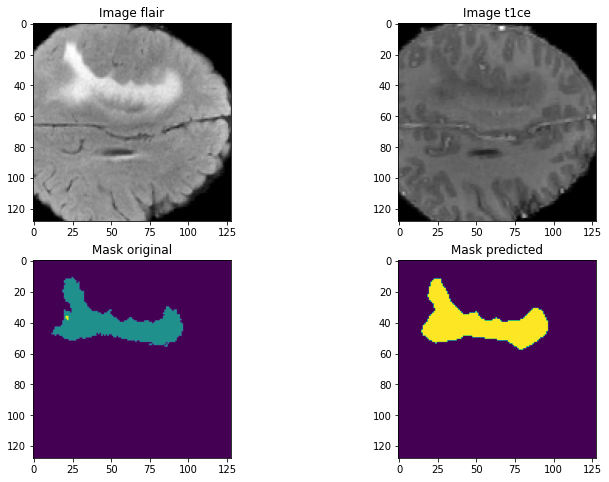

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=0
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

1 3


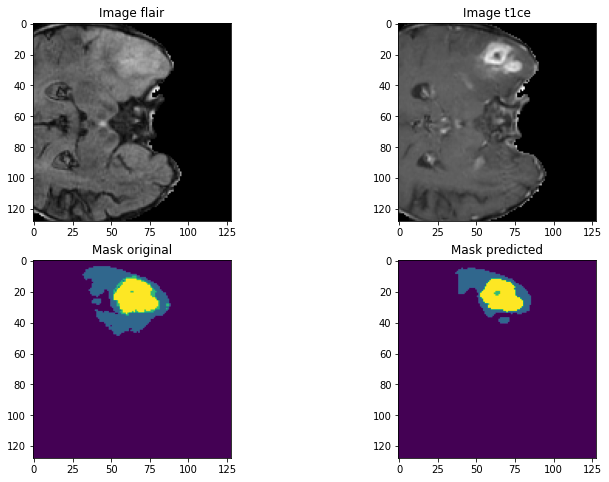

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

32 2


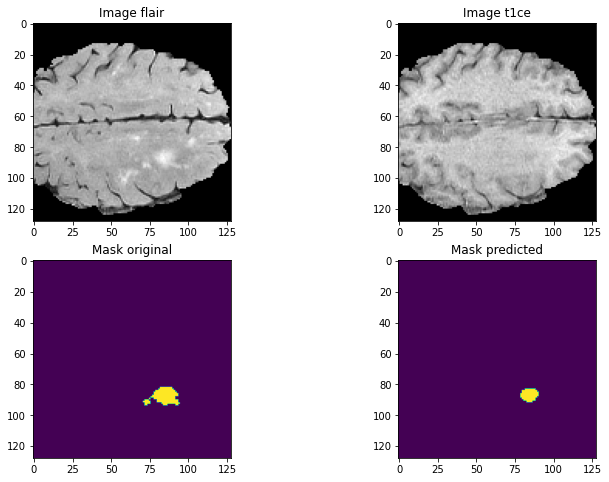

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

32 0


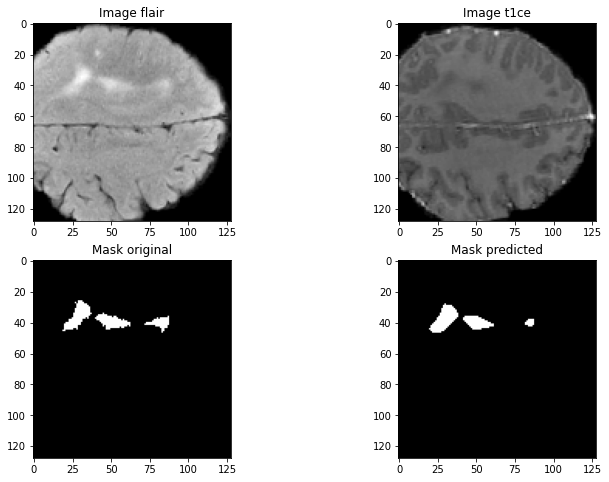

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=0
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice], cmap='gray')
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice], cmap='gray')
plt.title('Mask predicted')
plt.show()

# Inference with se block

In [ ]:
model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
checkpoint = torch.load('/content/Untitled Folder/weights_best_one.pth')
model.load_state_dict(checkpoint['weights'])

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
  for batch_idx, (inputs,outputs) in enumerate(tqdm(val_loader)):
    # inputs, targets = prepare_batch(batch, device)
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    logits = model(inputs).softmax(dim=CHANNELS_DIMENSION)

    # l = logits.cpu()
    # l = np.argmax(l, axis=1)
    # i = inputs.cpu()
    # o = outputs.cpu()
    # 0 = np.argmax(o, axis=1)

100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


In [ ]:
l = logits.cpu()
l = np.argmax(l, axis=1)
i = inputs.cpu()
o = outputs.cpu()
o = np.argmax(o, axis=1)

5 2


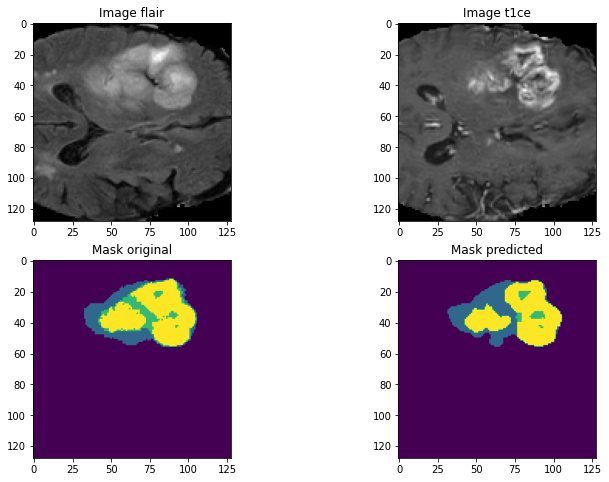

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

37 1


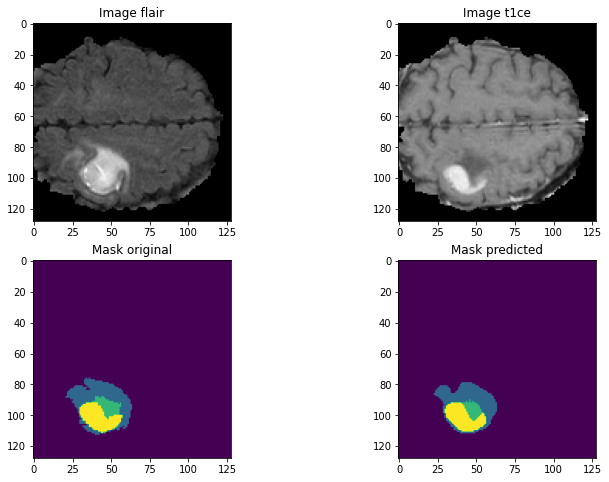

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=1
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

26 3


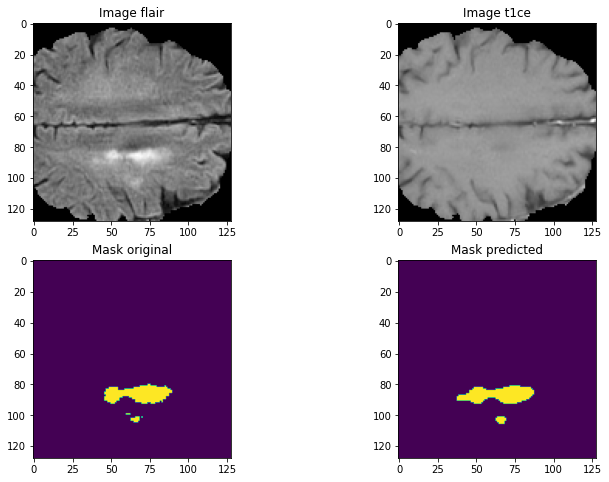

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

0 0


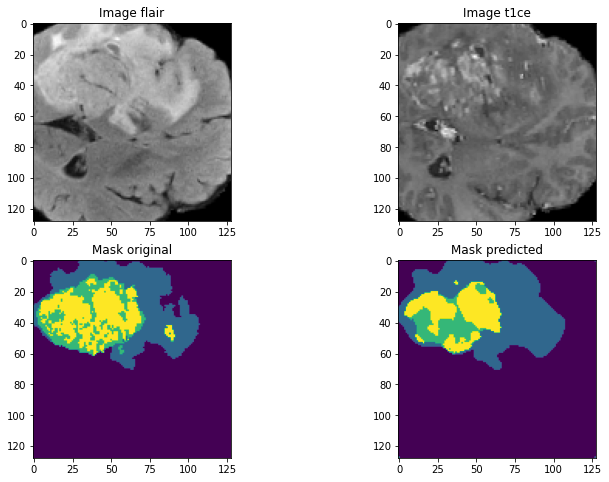

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=0
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

25 3


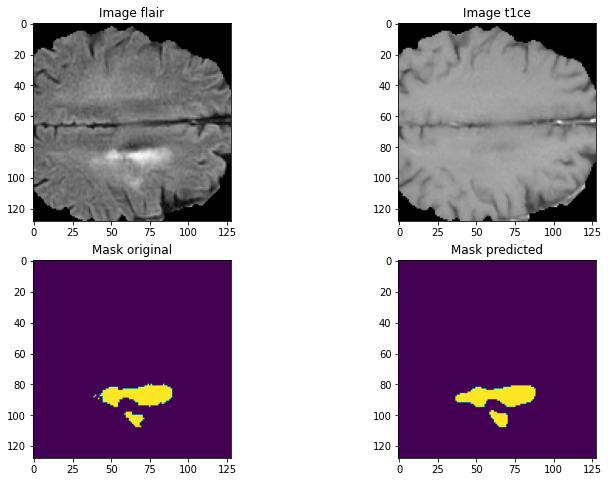

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

23 3


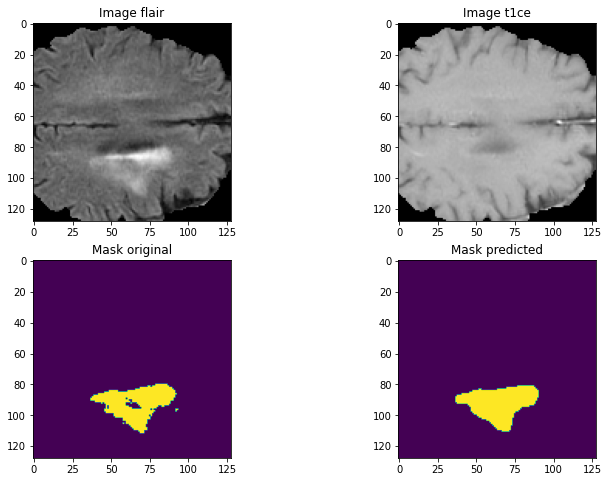

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

6 2


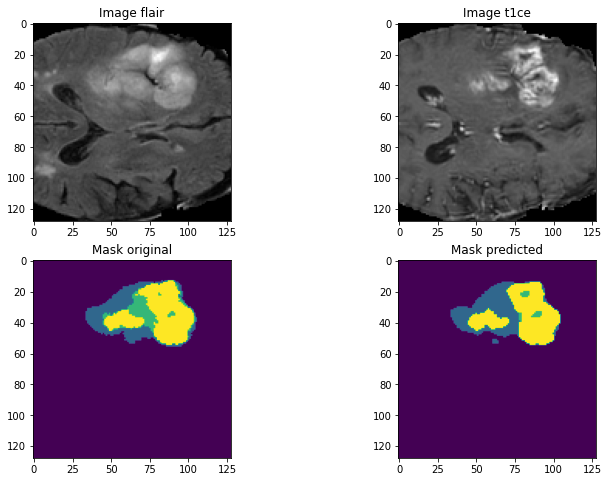

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

# inference with pe block...

In [ ]:
checkpoint = torch.load('/content/Untitled Folder/weights_best_one.pth')
model.load_state_dict(checkpoint['weights'])

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
  for batch_idx, (inputs,outputs) in enumerate(tqdm(val_loader)):
    # inputs, targets = prepare_batch(batch, device)
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    logits = model(inputs).softmax(dim=CHANNELS_DIMENSION)

    # l = logits.cpu()
    # l = np.argmax(l, axis=1)
    # i = inputs.cpu()
    # o = outputs.cpu()
    # 0 = np.argmax(o, axis=1)

100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


In [ ]:
l = logits.cpu()
l = np.argmax(l, axis=1)
i = inputs.cpu()
o = outputs.cpu()
o = np.argmax(o, axis=1)

3 2


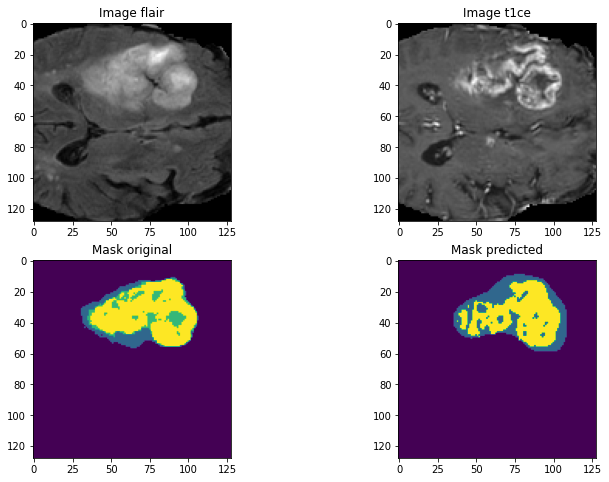

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=2
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

46 1


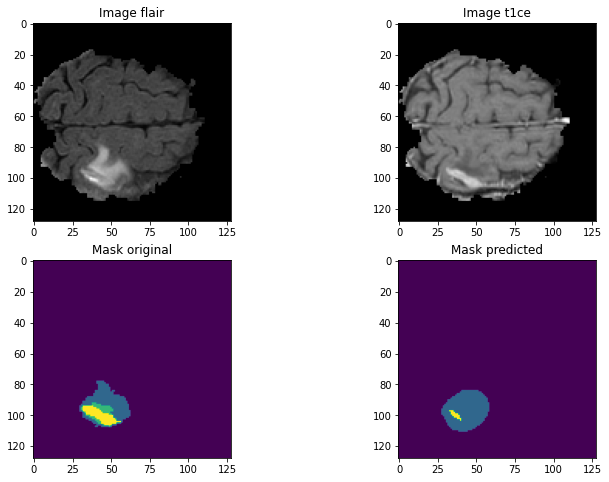

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=1
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

15 3


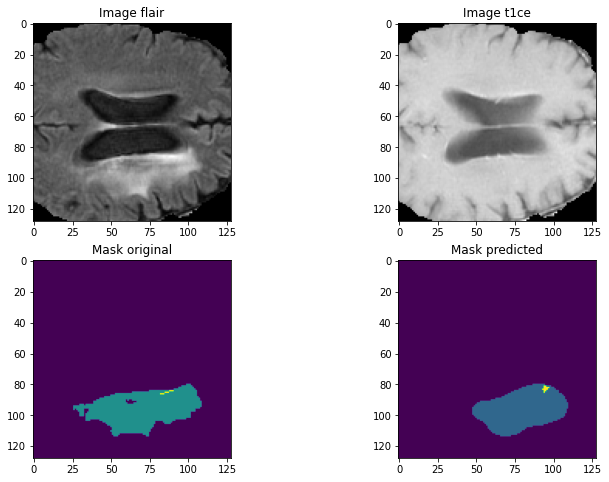

In [ ]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=3
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()

# New Dataloader

In [ ]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTr" 
TRAIN_MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsTr"
VAL_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesVal"
VAL_MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/labelsVal" 
TEST_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/brain/Task01_BrainTumour/imagesTs" 

In [ ]:
def make_list(s):
  l = sorted(os.listdir(s))
  return l

In [ ]:
images_train = make_list(TRAIN_IMG_DIR)
masks_train = make_list(TRAIN_MASK_DIR)
images_val = make_list(VAL_IMG_DIR)
masks_val = make_list(VAL_MASK_DIR)
images_test = make_list(TEST_IMG_DIR)
len(images_train), len(masks_train), len(images_val), len(masks_val), len(images_test)

In [ ]:
#list of img and mask path......TRAIN
img_train_paths = []
mask_train_paths = []
#list of img and mask path......VAL
img_val_paths = []
mask_val_paths = []
#list of img path.......TEST
img_test_paths = []

for idx in range(len(images_train)):
  img_train_paths.append(os.path.join(TRAIN_IMG_DIR, images_train[idx]))
  mask_train_paths.append(os.path.join(TRAIN_MASK_DIR, masks_train[idx]))

for idx in range(len(images_val)):
  img_val_paths.append(os.path.join(VAL_IMG_DIR, images_val[idx]))
  mask_val_paths.append(os.path.join(VAL_MASK_DIR, masks_val[idx]))

for idx in range(len(images_test)):
  img_test_paths.append(os.path.join(TEST_IMG_DIR, images_test[idx]))

len(img_train_paths), len(mask_train_paths), len(img_val_paths), len(mask_val_paths), len(img_test_paths)

In [ ]:
class BRaTSDataset(Dataset):
  def __init__(self, img_paths=None, mask_paths=None, transform_imgs=None, transform_mask=None):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transform_imgs = transform_imgs
    self.transform_mask = transform_mask
    if self.mask_paths is not None:
      assert len(self.img_paths) == len(self.mask_paths)
    self.images = len(self.img_paths) #list all the files present in that folder...
  
  def __len__(self):
    return len(self.img_paths) #length of dataset
  
  def __getitem__(self, index):
    img_path = self.img_paths[index]
    image = nib.load(img_path).get_fdata(dtype=np.float32)
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    image = image[56:184, 56:184, 73:121]
    image0 = image[:,:,:,0]
    image2 = image[:,:,:,2]
    image3 = image[:,:,:,3]
    image = np.stack((image0,image2,image3),axis=3)

    if self.mask_paths is not None:
      mask_path = self.mask_paths[index]
      mask = nib.load(mask_path).get_fdata(dtype=np.float32)
      mask = mask.astype(np.uint8)
      mask = mask[56:184, 56:184, 73:121]
      mask = to_categorical(mask, num_classes=4)

    # image = np.load(img_path)
    image = torch.from_numpy(image)
    image = image.permute(3,0,1,2)

    if self.mask_paths is not None:
      # mask = np.load(mask_path)
      mask = torch.from_numpy(mask)
      mask = mask.permute(3,0,1,2)
 
    if self.transform_imgs is not None:
      image = training_transforms(image)
    if self.transform_mask is not None:
      mask = training_transforms(mask)
    
    if self.mask_paths is not None:
      return image, mask
    if self.mask_paths is None:
      return image

In [ ]:
training_transforms = tio.Compose(
    [
    #  tio.RandomFlip(),
    #  tio.RandomAffine(degrees= 25),
    #  tio.RandomBlur(), 
    #  tio.RandomNoise(mean=0.6),
    #  tio.RandomGamma(),
    #  tio.RandomBiasField(p=0.3),
    #  tio.RandomElasticDeformation()
 ]
)

train_ds = BRaTSDataset(
        img_paths=img_train_paths,
        mask_paths=mask_train_paths,
        transform_imgs=training_transforms,
        transform_mask=training_transforms
    )

train_loader = DataLoader(
        train_ds,
        batch_size=4,
        num_workers=0,
        shuffle=True,
    )

In [ ]:
I,M = next(iter(train_loader))
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 4, 128, 128, 48])


In [ ]:
M=np.argmax(M, axis=1)
print("image...",I.shape,"Mask...", M.shape)

image... torch.Size([4, 3, 128, 128, 48]) Mask... torch.Size([4, 128, 128, 48])


36 1


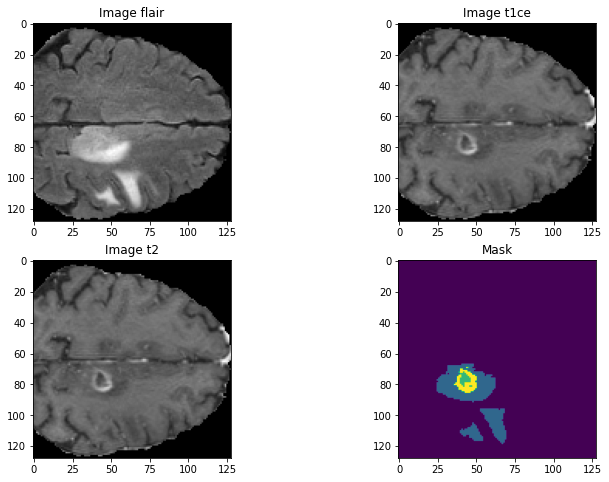

In [ ]:
n_slice=random.randint(0, M.shape[3])
plt.figure(figsize=(12, 8))
no=1
print(n_slice,no)

plt.subplot(221)
plt.imshow(I[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(I[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(M[no,:,:,n_slice])
plt.title('Mask')
plt.show()